In [1]:
import torch
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from PIL import Image
import pandas as pd
from torchvision import transforms
from sklearn.model_selection import train_test_split
#import preprocessing
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle as pkl
import torch.nn.functional as F

In [ ]:
!wget https://drive.google.com/drive/folders/1kAMie387KrGXkwaVJayhtCWP2oPOVLvy?usp=sharing
!wget https://drive.google.com/drive/u/2/folders/1kAMie387KrGXkwaVJayhtCWP2oPOVLvy?q=parent:1kAMie387KrGXkwaVJayhtCWP2oPOVLvy%20sharedwith:public

--2024-01-09 11:49:59--  https://drive.google.com/drive/folders/1kAMie387KrGXkwaVJayhtCWP2oPOVLvy?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.250.136.100, 142.250.136.138, 142.250.136.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.136.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘1kAMie387KrGXkwaVJayhtCWP2oPOVLvy?usp=sharing’

1kAMie387KrGXkwaVJa     [ <=>                ] 242.07K  1.43MB/s    in 0.2s    

2024-01-09 11:50:00 (1.43 MB/s) - ‘1kAMie387KrGXkwaVJayhtCWP2oPOVLvy?usp=sharing’ saved [247881]



In [ ]:
!ls

'1kAMie387KrGXkwaVJayhtCWP2oPOVLvy?usp=sharing'   gdrive		    UTKFace
 crop_part1					  sample_data		    utkface_aligned_cropped
 data						  trained_multi_model.pkl


In [ ]:
import zipfile


# unzip the downloaded file
zip_ref = zipfile.ZipFile("UTK_dataset.zip")
zip_ref.extractall()
zip_ref.close()

FileNotFoundError: [Errno 2] No such file or directory: 'UTK_dataset.zip'

In [ ]:
!pip install gdown

direct_download_link = 'https://drive.google.com/uc?id=1kAMie387KrGXkwaVJayhtCWP2oPOVLvy'
destination = 'UTK_dataset.zip'

# Download the file using gdown
!gdown $direct_download_link -O $destination

# Unzip the downloaded file
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall()

# Remove the zip file if you want
os.remove(destination)

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1kAMie387KrGXkwaVJayhtCWP2oPOVLvy 



BadZipFile: File is not a zip file

In [ ]:
!pip install gdown

# Replace 'YOUR_FILE_ID' with the ID of your shared file
file_id = 'https://drive.google.com/drive/folders/1kAMie387KrGXkwaVJayhtCWP2oPOVLvy?usp=sharing'
destination = 'UTK_dataset.zip'

# Download the file using gdown
!gdown --id $file_id -O $destination

# Unzip the downloaded file
!unzip UTK_dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=https://drive.google.com/drive/folders/1kAMie387KrGXkwaVJayhtCWP2oPOVLvy?usp=sharing 

unzip:  cannot find or open UTK_dataset.zip, UTK_dataset.zip.zip or UTK_dataset.zip.ZIP.


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
!unzip gdrive/MyDrive/ML_Datasets/UTK_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [3]:

def split_data(df):
    train_ratio = 0.7
    val_ratio = 0.2
    test_ratio = 0.1

    df_use, df_discard = train_test_split(df, test_size=0.95, random_state=42)

    train_val, test = train_test_split(df_use, test_size=test_ratio, random_state=42)
    train, val = train_test_split(train_val, test_size=val_ratio/(train_ratio + val_ratio), random_state=42)

    return train, val, test

In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, dataframe, transform=None):
        self.image_folder = image_folder
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0] + '.jpg'  # Assuming the image column is 'Image_ID'
        age = torch.tensor(self.dataframe.iloc[idx,1])
        gender = torch.tensor(self.dataframe.iloc[idx,2])

        # Lazy loading: return the image path and label instead of loading the image
        return img_name, [age,gender]

    def load_image(self, img_name):
        img_path = self.image_folder + '/' + img_name
        image = Image.open(img_path).convert('L')
        #need a transformer for test images just to convert to tensor and to resahape and allat
        if self.transform == 'train' or self.transform == 'test':
            # Define transformations for data augmentation
            transform = transforms.Compose([
                transforms.Resize((100, 100)),
                transforms.RandomHorizontalFlip(),
                # transforms.RandomRotation(20),
                transforms.ToTensor(),
                transforms.Grayscale(num_output_channels=1),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ])
            image = transform(image)
        elif self.transform == "test":
            transform = transforms.Compose([
                transforms.Resize((100, 100)),
                transforms.ToTensor(),
                transforms.Grayscale(num_output_channels=1),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ])
            image = transform(image)
        return image

In [5]:
import pandas as pd
import os

# Function to rename files in a directory
def rename_files(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg.chip.jpg"):
            # Create the new filename by replacing '.jpg.chip.jpg' with '.jpg'
            new_filename = filename.replace('.jpg.chip.jpg', '.jpg')

            # Construct the full file paths
            current_filepath = os.path.join(folder_path, filename)
            new_filepath = os.path.join(folder_path, new_filename)

            # Rename the file
            os.rename(current_filepath, new_filepath)
            #print(f"Renamed {filename} to {new_filename}")

# Function to extract information from image file names
def extract_info_from_filename(filename):
    # Split the filename by underscores
    parts = filename.split('_')
    # Extract relevant information
    age = int(parts[0])
    gender = int(parts[1])
    race = int(parts[2])
    return age, gender, race

def can_extract_info(filename):
    parts = filename.split('_')
    if (len(parts)<4):
        print(filename + " has missing values.")
        return False
    else:
        return True

# Function to get image file names in a folder
def get_image_info(folder_path):
    image_info = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):  # Consider only JPG files
            if can_extract_info(filename):
                age, gender, race = extract_info_from_filename(filename)
                image_id = os.path.splitext(filename)[0]  # Remove file extension to get image ID
                image_info.append((image_id, age, gender, race))

    return image_info

# Create a DataFrame from image information
def create_dataframe(folder_path):
    image_info = get_image_info(folder_path)
    df = pd.DataFrame(image_info, columns=['Image_ID', 'Age', 'Gender', 'Race'])
    return df


folder_path = 'UTKFace'

rename_files(folder_path)

# Define the directory to save the DataFrame
output_directory = 'data'

# Create the directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the output file path
output_file_path = os.path.join(output_directory, 'UTKFace_labels.csv')

print(output_file_path)

# Save the DataFrame to a CSV file in the new directory
image_dataframe = create_dataframe(folder_path)
image_dataframe.to_csv(output_file_path, index=False)

data/UTKFace_labels.csv
61_1_20170109142408075.jpg has missing values.
39_1_20170116174525125.jpg has missing values.
61_1_20170109150557335.jpg has missing values.


In [6]:
data_path = 'UTKFace'
batch_size=32
df = pd.read_csv('data/UTKFace_labels.csv', dtype={'Age':'float32', 'Gender':'float32'})
train_data, val_data, test_data = split_data(df)

In [7]:
train_dataset = CustomDataset(dataframe=train_data, image_folder=data_path, transform='train')
val_dataset = CustomDataset(dataframe=val_data, image_folder=data_path, transform='val')
test_dataset = CustomDataset(dataframe=test_data, image_folder=data_path, transform='test')

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# Iterate through the train_loader to get a batch of data
for batch_idx, (img_names, targets) in enumerate(train_loader):
    data = [train_dataset.load_image(img_name) for img_name in img_names]
    example_data = data  # This will contain a batch of images
    example_targets = targets  # This will contain the corresponding labels/targets
    break

In [10]:
tf.print(example_data)

[tensor([[[-0.5294, -0.5216, -0.5608,  ...,  0.9529,  0.9686,  0.9765],
         [-0.0902, -0.1529, -0.3647,  ...,  0.9451,  0.9451,  0.9765],
         [ 0.0667,  0.0118, -0.1922,  ...,  0.9529,  0.9529,  0.9843],
         ...,
         [-0.6863, -0.6627, -0.6000,  ..., -0.1922, -0.1686,  0.0275],
         [-0.7255, -0.6392, -0.6000,  ..., -0.1922, -0.2314,  0.0275],
         [-0.6941, -0.5608, -0.6235,  ..., -0.1922, -0.2078,  0.0588]]]),
 tensor([[[ 0.3098,  0.2392,  0.2000,  ..., -0.2706, -0.3490, -0.3490],
         [ 0.2784,  0.2471,  0.2000,  ..., -0.3412, -0.3647, -0.3333],
         [ 0.2235,  0.2314,  0.1922,  ..., -0.5059, -0.4431, -0.3176],
         ...,
         [-0.0196, -0.0275, -0.4196,  ...,  0.0431,  0.0275,  0.0824],
         [-0.0431, -0.1843, -0.5451,  ...,  0.2784,  0.2235,  0.1922],
         [-0.0667, -0.3255, -0.6000,  ...,  0.4353,  0.3725,  0.3020]]]),
 tensor([[[-0.8588, -0.7961, -0.7412,  ..., -0.9608, -0.9608, -0.9686],
         [-0.8510, -0.7882, -0.7490,  ..

In [11]:
tf.print(example_targets)

[tensor([12., 23., 23., 49., 21., 40., 43., 60., 30., 24., 18.,  2., 60., 85.,
        10., 28., 36., 45., 30., 15., 35., 69., 55., 36., 27., 45., 27.,  1.,
        29., 28., 26., 24.]),
 tensor([1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1.])]


In [12]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dense_shared = nn.Linear(50 * 50 * 64, 128)  # Calculate the input size based on your input_shape

        # Output layers
        self.classification_output = nn.Linear(128, 1)
        self.regression_output = nn.Linear(128, 1)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Identity()  # No activation for linear output

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.max_pool(x)

        # Flatten and pass through fully connected layers
        x = self.flatten(x)
        x = self.relu(self.dense_shared(x))

        # Classification branch
        classification_out = self.sigmoid(self.classification_output(x)).squeeze()

        # Regression branch
        regression_out = self.linear(self.regression_output(x)).squeeze()

        return regression_out, classification_out

In [13]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskLossWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, age_pred, gen_pred, age_true, gen_true):
        mse, binCrossEntropy = nn.MSELoss(), nn.BCELoss()

        loss0 = mse(age_pred, age_true)
        loss1 = binCrossEntropy(gen_pred, gen_true)

        precision0 = torch.exp(-self.log_vars[0])
        loss0 = precision0*loss0 + self.log_vars[0]

        precision1 = torch.exp(-self.log_vars[1])
        loss1 = precision1*loss1 + self.log_vars[1]

        return loss0+loss1

In [14]:
model = CustomModel()
loss_func = MultiTaskLossWrapper(2)

In [15]:
# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate as needed

# Training loop
val_losses = []
train_losses = []
epochs = 10  # Define the number of epochs for training
for epoch in range(epochs):
    print("epoch:", epoch)
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for batch_idx, (img_names, targets) in enumerate(train_loader):
        print(batch_idx)
        data = torch.stack([train_dataset.load_image(img_name) for img_name in img_names])
        # print(type(data))
        optimizer.zero_grad()  # Zero the gradients to prevent accumulation
        age_pred, gen_pred = model(data)  # Forward pass
        #print(gen_pred)
        #print(age_pred)
        age_true = targets[0]
        gen_true = targets[1]
        loss = loss_func(age_pred, gen_pred, age_true, gen_true)
        total_loss += loss.item()
        # Backpropagation
        loss.backward()
        optimizer.step()

    # Calculate average loss for the epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0.0
        for batch_idx, (img_names, targets) in enumerate(val_loader):
            data = torch.stack([train_dataset.load_image(img_name) for img_name in img_names])
            age_pred, gen_pred = model(data)  # Forward pass
            age_true = targets[0]
            gen_true = targets[1]
            loss = loss_func(age_pred, gen_pred, age_true, gen_true)
            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch + 1}/{epochs}] - Validation Loss: {avg_val_loss:.4f}")

# Save the trained model using pickle
filename = 'trained_multi_model.pkl'
with open(filename, 'wb') as file:
    pkl.dump(model, file)

epoch: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Epoch [1/10], Loss: 673.4246
Epoch [1/10] - Validation Loss: 355.6212
epoch: 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Epoch [2/10], Loss: 352.5161
Epoch [2/10] - Validation Loss: 326.2770
epoch: 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Epoch [3/10], Loss: 319.4520
Epoch [3/10] - Validation Loss: 268.4373
epoch: 3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Epoch [4/10], Loss: 308.7503
Epoch [4/10] - Validation Loss: 244.3529
epoch: 4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Epoch [5/10], Loss: 278.5295
Epoch [5/10] - Validation Loss: 274.9635
epoch: 5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Epoch [6/10], Loss: 234.4235
Epoch [6/10] - Validation Loss: 233.3285
epoch: 6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Epoch [7/10], Loss: 213.5955
Epoch [7/10]

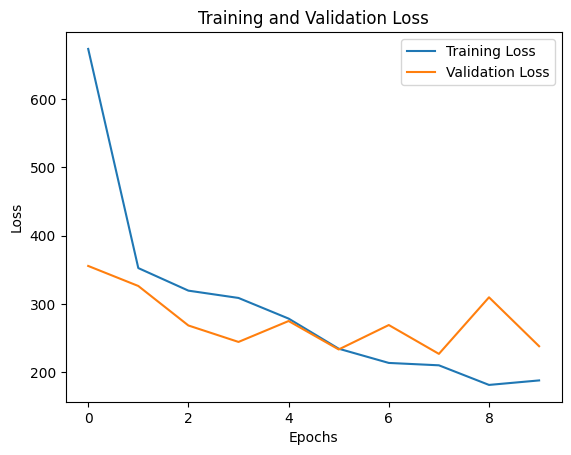

In [16]:
# Plotting losses over epochs
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluation time

In [17]:
# Calculate the mean value in the training set (to use as the baseline prediction)
def baseline_calc(index):
  train_targets = []  # Collect training targets
  for _, targets in train_loader:
    train_targets.extend(targets[index].numpy())

  return torch.tensor(train_targets).float().mean().item()

# Calculate MSE for baseline predictions (always predicting the mean)
def baseline_evaluation(targets, baseline_pred):
  return F.mse_loss(torch.full_like(targets, baseline_pred), targets, reduction='sum').item()

# Calculate MSE for model predictions
def model_evaluation(test_pred, targets):
  return F.mse_loss(test_pred, targets, reduction='sum').item()


In [18]:
def eval(task, total_correct, total_samples, random_chance, total_mse_model, total_mse_baseline, threshold = None):
  # Calculate overall accuracy
  accuracy = total_correct / total_samples

  # Print random chance accuracy
  print(f"Random chance based on label ratio for {task} prediction: {random_chance * 100:.2f}%")
  # Print model accuracy
  if task == "age":
    print(f"Accuracy on test set for {task}{threshold}: {accuracy * 100:.2f}%")
  else:
    print(f"Accuracy on test set for {task}: {accuracy * 100:.2f}%")

  # Compare accuracy against random chance
  if accuracy > random_chance:
      print(f"Model performs better than random chance for {task}.")
  else:
      print(f"Model performs no better than random chance for {task}.")

  # Calculate average MSE for both model and baseline
  avg_mse_model = total_mse_model / total_samples
  avg_mse_baseline = total_mse_baseline / total_samples

  # Print MSE values
  print(f"{task.capitalize()} Model MSE: {avg_mse_model:.4f}")
  print(f"{task.capitalize()} Baseline (Predicting Mean) MSE: {avg_mse_baseline:.4f}")

  # Calculate and print the improvement in MSE over the baseline
  mse_improvement = avg_mse_baseline - avg_mse_model
  print(f"{task.capitalize()} Improvement over baseline MSE: {mse_improvement:.4f}")

In [25]:
# Prediction loop
model.eval()  # Set the model to evaluation mode
predictions = []
targets = []

#Choose the error for which we consider age predictions correct
age_threshold = 5

# Initialize variables to track correct predictions and count labels
total_correct_gender = 0
total_correct_age = 0
total_samples_gender = 0
total_samples_age = 0
label_0_count = 0
label_1_count = 0


# Initialize variables for MSE calculation
total_mse_baseline_gen = 0.0
total_mse_model_gen = 0.0
total_mse_baseline_age = 0.0
total_mse_model_age = 0.0

#Calculate baseline
baseline_prediction_gen = baseline_calc(index = 0)
baseline_prediction_age = baseline_calc(index = 1)


with torch.no_grad():
    for (test_img_names, test_targets) in test_loader:
        test_data = torch.stack([test_dataset.load_image(img_name) for img_name in test_img_names])
        test_age_pred, test_gen_pred = model(test_data)  # Forward pass
        test_gen_pred = (test_gen_pred.squeeze() > 0.5).float()

        # Separate age and gender targets
        age_targets, gender_targets = test_targets

        ###############GENDER######################
        # Check correctness for gender prediction
        for i in range(len(gender_targets)):
            if test_gen_pred[i] == gender_targets[i]:
                total_correct_gender += 1

            # Count occurrences of label 0 and label 1
            if gender_targets[i] == 0:
                label_0_count += 1
            elif gender_targets[i] == 1:
                label_1_count += 1

        total_samples_gender += len(gender_targets)

        #Calculate MSE for gender predictions
        total_mse_baseline_gen += baseline_evaluation(gender_targets, baseline_prediction_gen)
        total_mse_model_gen += model_evaluation(test_gen_pred, gender_targets)

        ####################AGE#######################
        # Calculate correctness for age prediction within the threshold
        age_errors = torch.abs(test_age_pred - age_targets)
        correct_age_predictions = age_errors <= age_threshold
        total_correct_age += correct_age_predictions.sum().item()

        total_samples_age += len(age_targets)

        #Calculate MSE for age predictions
        total_mse_baseline_age += baseline_evaluation(age_targets, baseline_prediction_age)
        total_mse_model_age += model_evaluation(test_age_pred, age_targets)

        #print("Age Predictions:", test_age_pred)
        #print("Actual Age Targets:", age_targets)



############################## GENDER RANDOM CHANCE ##########################
# Adjust random chance according to label ratio
total_label_count = label_0_count + label_1_count
random_chance_gender = max(label_0_count, label_1_count) / total_label_count  # Assuming label 1 is the positive class
# Print label counts and random chance based on label ratio
#print(f"Label 0 count: {label_0_count}")
#print(f"Label 1 count: {label_1_count}")

############################## AGE RANDOM CHANCE ############################
# Aggregate all age targets from the entire test dataset
all_age_targets = []
for (test_img_names, test_targets) in test_loader:
    age_targets, _ = test_targets
    all_age_targets.append(age_targets)

# Concatenate the age targets from all batches
all_age_targets = torch.cat(all_age_targets, dim=0)

# Round the tensor to the nearest integer
all_age_targets = torch.round(all_age_targets)
# Convert the tensor to int as bincount wants int
all_age_targets = all_age_targets.int()

# Calculate bincount
age_label_counts = torch.bincount(all_age_targets)
max_age_label_count = age_label_counts.max().item()
# assuming uniform distribution for simplicity
random_chance_age = max_age_label_count / len(all_age_targets)

############################ PRINTING INFORMATION ##############################

threshold_info = " with a threshold of +-" + str(age_threshold) + " years"

print("GENDER EVALUATION:")
eval("gender", total_correct_gender, total_samples_gender, random_chance_gender, total_mse_model_gen, total_mse_baseline_gen)
print("\n")
print("AGE EVALUATION:")
eval("age", total_correct_age, total_samples_age, random_chance_age, total_mse_model_age, total_mse_baseline_age, threshold_info)

GENDER EVALUATION:
Random chance based on label ratio for gender prediction: 51.26%
Accuracy on test set for gender: 70.59%
Model performs better than random chance for gender.
Gender Model MSE: 0.2941
Gender Baseline (Predicting Mean) MSE: 1100.6604
Gender Improvement over baseline MSE: 1100.3663


AGE EVALUATION:
Random chance based on label ratio for age prediction: 8.40%
Accuracy on test set for age with a threshold of +-5 years: 27.73%
Model performs better than random chance for age.
Age Model MSE: 247.8296
Age Baseline (Predicting Mean) MSE: 1355.6100
Age Improvement over baseline MSE: 1107.7803


In [26]:
import torch
import pickle

# Load the model from the pickle file
with open('trained_multi_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Convert to state dictionary
state_dict = model.state_dict()

# Save as PyTorch serialized model
torch.save(state_dict, 'model_weights.pth')